PyTorch Plant Health Classification model. Trains on dataset with images of corn excluded to use as testing data. Training images are 16x16 crops taken from single leaf images and normalized.


In [ ]:
!git clone https://github.com/digitalepidemiologylab/plantvillage_deeplearning_paper_dataset.git

fatal: destination path 'plantvillage_deeplearning_paper_dataset' already exists and is not an empty directory.


In [ ]:
import os
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from PIL import Image
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt


directory = '/content/plantvillage_deeplearning_paper_dataset/raw/segmented'
healthy_dir = []
unhealthy_dir = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if 'healthy' in str(f):
      healthy_dir.append(f)
    else:
        unhealthy_dir.append(f)
print(healthy_dir)
print(unhealthy_dir)
healthy = []
unhealthy = []
val_health = []
val_uhealth = []
for dir in healthy_dir:
  if 'Corn' not in str(dir):
    for filename in os.listdir(dir):
      f = os.path.join(dir, filename)
      healthy.append(f)
  else:
    for filename in os.listdir(dir):
      f = os.path.join(dir, filename)
      val_health.append(f)
for dir in unhealthy_dir:
  if 'Corn' not in str(dir):
    for filename in os.listdir(dir):
      f = os.path.join(dir, filename)
      unhealthy.append(f)
  else:
    for filename in os.listdir(dir):
      f = os.path.join(dir, filename)
      val_uhealth.append(f)
print(len(healthy))
print(len(unhealthy))

['/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Peach___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Potato___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Pepper,_bell___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Tomato___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Raspberry___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Grape___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Apple___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Blueberry___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Soybean___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Strawberry___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Corn_(maize)___healthy', '/content/plantvillage_deeplearning_paper_dataset/raw/segmented/Ch

In [ ]:
import numpy as np
#code to display a torch image
def imshow(img, correct = True):
    if(correct):
      img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def draw_box(image, tl, size, thickness = 2, color = 1):
  t = thickness
  image[color,tl[0]:tl[0]+ size,tl[1]: tl[1] + t] = 1 #left vertical
  image[color,tl[0]: tl[0] + t,tl[1]:tl[1]+ size] = 1 #top horizontal
  image[color,tl[0]:tl[0]+ size,tl[1] + size: tl[1] + size - t] = 1 #right vertical
  image[color,tl[0] + size: tl[0] + size - t,tl[1]:tl[1]+ size] = 1 #bottom horizontal
  return image

def label_grid(image, size, draw_box):
  x = 0
  for i in range(image.shape[1] // size):
    for j in range(image.shape[2] // size):
      image = draw_box(image, (i*size,j*size), size, color = 0)
      x += 1
  return image

In [ ]:
def grid_image(image, size = 32):
  imgs = []
  for i in range(image.shape[1] // size):
    for j in range(image.shape[2] // size):
      img = image[:,i*size:(i+1)*size, j*size:(j+1)*size]
      if torch.mean(img) > 0.1 and img.shape == (3,size,size):
        imgs.append(img)
  return imgs

In [ ]:
from torch.utils.data import Dataset
import random
class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform=None, target_transform=None):
        self.img_labels = labels
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = transforms.ToTensor()(Image.open(self.imgs[idx]))
        if image.shape[0] < 3:
          image = torch.cat([image]*3, 0)
        else:
          image = image[:3]
        imgs = grid_image(image, 16)
        if len(imgs) != 0:
          image = random.choice(imgs)
        else:
          image = transforms.Resize((16,16))(image)
        image = torch.Tensor.float(transform(image))
        label = [0,0]
        label[self.img_labels[idx]] = 1
        label = torch.Tensor(label)
        return image, label

In [ ]:
import random
def split(dataset, r = 0.8):
  k = int(r*len(dataset))
  train_idx = random.sample(list(range(len(dataset))), k = k)
  test_idx = [i for i in range(len(dataset)) if i not in train_idx]
  train_data = [dataset[i] for i in train_idx]
  test_data = [dataset[i] for i in test_idx]
  return train_data, test_data


In [ ]:
h_train, h_test = split(healthy)
u_train, u_test = split(unhealthy)
train = h_train + u_train
tr_labels = [1 for i in range(len(h_train))] + [0 for i in range(len(u_train))]
test = h_test + u_test
t_labels = [1 for i in range(len(h_test))] + [0 for i in range(len(u_test))]
transform = transforms.Compose([ transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
test_transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
train_set = CustomImageDataset(tr_labels, train, transform = transform)
test_set = CustomImageDataset(t_labels, test, transform = test_transform)

In [ ]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images[0])
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(144, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
from tqdm import tqdm
losses = []
device = 'cuda'
net = net.to(device)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    losses.append(running_loss)
PATH = f'AgriHope.pth'
torch.save(net.state_dict(), PATH)

print('Finished Training')

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2003it [01:04, 33.27it/s]

[1,  2000] loss: 0.671


4005it [02:06, 32.27it/s]

[1,  4000] loss: 0.634


6002it [03:15, 28.81it/s]

[1,  6000] loss: 0.610


8004it [04:21, 33.58it/s]

[1,  8000] loss: 0.605


10004it [05:25, 30.33it/s]

[1, 10000] loss: 0.597


10091it [05:28, 30.71it/s]
2004it [01:03, 30.41it/s]

[2,  2000] loss: 0.592


4005it [02:07, 30.80it/s]

[2,  4000] loss: 0.587


6006it [03:11, 32.00it/s]

[2,  6000] loss: 0.583


8003it [04:16, 26.74it/s]

[2,  8000] loss: 0.586


10003it [05:27, 28.95it/s]

[2, 10000] loss: 0.581


10091it [05:31, 30.47it/s]
2005it [01:05, 30.70it/s]

[3,  2000] loss: 0.574


4005it [02:09, 32.30it/s]

[3,  4000] loss: 0.572


6004it [03:12, 30.36it/s]

[3,  6000] loss: 0.560


8005it [04:16, 32.56it/s]

[3,  8000] loss: 0.554


10004it [05:20, 30.61it/s]

[3, 10000] loss: 0.547


10091it [05:22, 31.26it/s]
2004it [01:07, 30.28it/s]

[4,  2000] loss: 0.533


4006it [02:15, 32.58it/s]

[4,  4000] loss: 0.532


6006it [03:18, 30.57it/s]

[4,  6000] loss: 0.519


8004it [04:20, 31.20it/s]

[4,  8000] loss: 0.533


10002it [05:24, 32.15it/s]

[4, 10000] loss: 0.517


10091it [05:26, 30.87it/s]
2006it [01:02, 31.91it/s]

[5,  2000] loss: 0.520


4003it [02:09, 30.28it/s]

[5,  4000] loss: 0.512


6002it [03:21, 27.29it/s]

[5,  6000] loss: 0.518


8006it [04:32, 30.32it/s]

[5,  8000] loss: 0.501


10006it [05:39, 30.47it/s]

[5, 10000] loss: 0.503


10091it [05:42, 29.47it/s]
2005it [01:06, 28.98it/s]

[6,  2000] loss: 0.509


4003it [02:12, 30.43it/s]

[6,  4000] loss: 0.502


6005it [03:16, 33.11it/s]

[6,  6000] loss: 0.500


8004it [04:26, 27.16it/s]

[6,  8000] loss: 0.512


10005it [05:35, 31.42it/s]

[6, 10000] loss: 0.503


10091it [05:37, 29.86it/s]
2003it [01:04, 31.67it/s]

[7,  2000] loss: 0.504


4004it [02:08, 32.04it/s]

[7,  4000] loss: 0.500


6004it [03:12, 31.37it/s]

[7,  6000] loss: 0.506


8003it [04:17, 30.87it/s]

[7,  8000] loss: 0.510


10006it [05:22, 31.88it/s]

[7, 10000] loss: 0.503


10091it [05:25, 31.04it/s]
2002it [01:09, 27.37it/s]

[8,  2000] loss: 0.507


4001it [02:20, 27.31it/s]

[8,  4000] loss: 0.502


6002it [03:27, 20.45it/s]

[8,  6000] loss: 0.505


8004it [04:33, 29.41it/s]

[8,  8000] loss: 0.498


10004it [05:37, 30.30it/s]

[8, 10000] loss: 0.492


10091it [05:40, 29.66it/s]
2004it [01:05, 31.64it/s]

[9,  2000] loss: 0.488


4005it [02:09, 33.75it/s]

[9,  4000] loss: 0.500


6003it [03:18, 30.23it/s]

[9,  6000] loss: 0.502


8003it [04:24, 30.28it/s]

[9,  8000] loss: 0.499


10005it [05:27, 31.82it/s]

[9, 10000] loss: 0.497


10091it [05:30, 30.55it/s]
2006it [01:04, 32.56it/s]

[10,  2000] loss: 0.502


4005it [02:06, 33.17it/s]

[10,  4000] loss: 0.493


6006it [03:10, 30.66it/s]

[10,  6000] loss: 0.507


8004it [04:17, 27.62it/s]

[10,  8000] loss: 0.492


10004it [05:29, 30.85it/s]

[10, 10000] loss: 0.489


10091it [05:32, 30.35it/s]

Finished Training


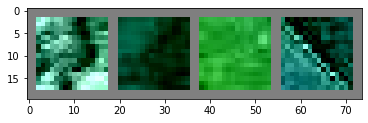

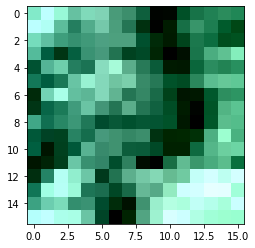

tensor([[[ 0.0227,  0.4851,  0.1939, -0.1999,  0.0056,  0.0056, -0.4226,
          -0.5253, -0.8849, -1.5870, -1.5870, -1.0562, -0.8164, -0.7479,
          -0.6623, -0.7479],
         [ 0.4679,  0.3823, -0.2684, -0.7137, -0.3541, -0.0801, -0.4054,
          -0.7137, -1.2445, -1.6042, -1.4158, -0.8164, -0.5596, -0.7650,
          -1.0390, -1.2445],
         [-0.0801, -0.2513, -0.5082, -0.5767, -0.4911, -0.3883, -0.3883,
          -0.3883, -1.0048, -1.2959, -1.4329, -1.1418, -0.7822, -0.9020,
          -1.1418, -1.1589],
         [-0.3369, -1.0048, -1.3130, -0.9534, -0.5424, -0.4397, -0.7308,
          -1.1075, -1.0562, -1.3302, -1.7240, -1.5528, -0.7993, -0.4054,
          -0.2513,  0.0398],
         [-1.1418, -0.3369, -0.1314, -0.7137, -0.7822,  0.0741,  0.3138,
          -0.2856, -0.6794, -0.9192, -1.4329, -1.4843, -0.9192, -0.6623,
          -0.7308, -0.6794],
         [-0.8507, -1.0048, -0.7993, -0.1828,  0.1939,  0.0398, -0.1143,
          -0.0287, -0.5596, -0.6965, -1.0048, -1.090

AttributeError: ignored

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
imshow(images[0])
print(images[0]).shape

In [ ]:
outputs = net(images)

In [ ]:
print(labels)

In [ ]:
_, predicted = torch.max(outputs, 1)
print(predicted)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [ ]:
print(f'Train Accuracy of the network: {100 * correct // total} %')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:,1]).sum().item()


In [ ]:
print(f'Test Accuracy of the network: {100 * correct // total} %')

Test Accuracy of the network: 74 %


In [ ]:
val = val_health + val_uhealth
v_labels = [1 for i in range(len(val_health))] + [0 for i in range(len(val_uhealth))]

In [ ]:
val_set = CustomImageDataset(v_labels, val, transform = test_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:,1]).sum().item()

In [ ]:
print(f'Test Accuracy of the network: {100 * correct // total} %')


Test Accuracy of the network: 71 %
